# Magistère 2A INTRODUCTION AU MACHINE LEARNING
## TP 4 : Apprentissage équitable

## Objectifs du TP

Dans ce TP, on utilisera la base `adult`. Le but de cette base est de prédire si le salaire sera supérieur à 50 000\$ à partir d'information socio-économique et de corriger les biais lié au genre ou à la catégorie ethnique.

Le TP sera à rendre en binôme pour le 6 décembre 2020.

pour installer XGboost :

pip install xgboost

## Chargement de la base et sélection des données

* Téléchargez la base *adult.csv* et chargez-la dans un DataFrame (pandas), noté *df* (pandas).
* Affichez les attributs de la base et leur nombre. De quel type sont-ils (réels, nominaux ou variables binaires...) ? Combien y a-t-il de classes (colonne income) ?
*  vous devez maintenant nettoyer la base :
    * remplacer les valeurs manquantes par le mode à l'aide de *df.fillna*
    * remplacer dans la colonne *income* '<=50K' par 0 et  '>50K' par 1
    * remplacer dans la colonne *sex* 'male' par 0 et  'female' par 1
    * retirer la colonne *fnlwgt*
    * transformer les variables non numériques en variables binaires à l'aide de *pandas.get_dummies*
    * Pour les informations liées à la catégorie ethnique, ne gardez que la colonne correspondant à "white/not white"

* Créer une base d'apprentissage et une base de test (70\% apprentissage 30\% test)

In [1]:
import os
import pandas as pds
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from tqdm.auto import tqdm 

In [2]:
pds.set_option('display.max_columns', None)
df = pds.read_csv((os.path.join("data", "adult.csv")))
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [3]:
df.race.unique()

array(['White', 'Black', 'Asian-Pac-Islander', 'Other',
       'Amer-Indian-Eskimo'], dtype=object)

In [4]:
df.race = df.race.map({'White': 0, 'Black':1, 'Asian-Pac-Islander':1, 'Other':1, 'Amer-Indian-Eskimo':1})
df.race.unique()

array([0, 1], dtype=int64)

In [5]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race               int64
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

In [6]:
df = df.replace('?', np.NaN)
df = df.fillna( df.mode().iloc[0] )
df.income = df.income.map({'<=50K': 0,'>50K': 1})
df.sex = df.sex.map({'Female': 1,'Male': 0})
df = pds.concat([df, df.workclass.str.get_dummies()], axis=1)
df = pds.concat([df, df.education.str.get_dummies()], axis=1)
df = pds.concat([df, df['marital.status'].str.get_dummies()], axis=1)
df = pds.concat([df, df.occupation.str.get_dummies()], axis=1)
df = pds.concat([df, df.relationship.str.get_dummies()], axis=1)
df = pds.concat([df, df['native.country'].str.get_dummies()], axis=1)

df = df.drop(columns=['fnlwgt','workclass','education','marital.status','occupation','relationship','native.country'], axis=1)

In [7]:
df_train, df_test = train_test_split(df, test_size = 0.3)

X_test = df_test.drop('income', axis = 1)
Y_test = df_test['income']

X_train = df_train.drop('income', axis = 1)
Y_train = df_train['income']

## Calcul du biais
Faire une fonction *disparate_impact(Y,S)* qui prend deux vecteurs binaires, un correspondant à $\hat{Y}$ (ou $Y$) ,l'autre à $S$ et qui calcule le disparate impact :
$$
DI(\hat{Y},S)=\frac{P(\hat{Y}=1|S=0)}{P(\hat{Y}=1|S=1)}
$$
* calculer le disparate impact des bases train et test pour $Y$ correpondant à $income$ et $S$ correspondant à *sex* 
* calculer le disparate impact des bases train et test pour $Y$ correpondant à $income$ et $S$ correspondant à *white/not white*

In [15]:
def disparate_impact(Y,S):
    
    data = pds.DataFrame([Y,S]).transpose()
    data_tuple = list(data.itertuples(index=False, name=None))
    count_proba = dict(zip(Counter(data_tuple).keys(), Counter(data_tuple).values()))
    Y1_given_S0 = count_proba.get((1,0),0) / ( count_proba.get((1,0),0) + count_proba.get((0,0),0) )
    Y1_given_S1 = count_proba.get((1,1),0) / ( count_proba.get((1,1),0) + count_proba.get((0,1),0) )
    
    if Y1_given_S1 != 0:
        return Y1_given_S0 / Y1_given_S1
    else:
        return 100

### Pour le genre :

In [9]:
DI_train_income_sex = disparate_impact(Y_train, X_train.sex)
DI_test_income_sex = disparate_impact(Y_test, X_test.sex)

print('DI_train_income_sex',DI_train_income_sex)
print('DI_test_income_sex',DI_test_income_sex)

DI_train_income_sex 2.779457442797325
DI_test_income_sex 2.8251806696474993


### Pour la categorie ethnique :

In [10]:
DI_train_income_race = disparate_impact(Y_train, X_train.race)
DI_test_income_race = disparate_impact(Y_test, X_test.race)

print('DI_train_income_race',DI_train_income_race)
print('DI_test_income_race',DI_test_income_race)

DI_train_income_race 1.7080637201484032
DI_test_income_race 1.6112613394858053


Pour le genre comme pour la categorie ethnique, le disparate impact, qui mesure la dependance entre la variable a predire et la variable a proteger (genre ou categorie ethnique) est different de 1. Il y a donc, une grande dependance entre le revenu et le genre (dipararate impacte autour de 3), tout comme il en existe une entre le revnu et la categorie ethnique (dipararate impacte autour entre 1.5 et 2).

A l'aide de *scikit-learn* :
* Faire un classifieur pour prédire la classe *income*
* Prédire la class *income* sur la base de test (ce sera votre $\hat{Y}$)
* Calculer le taux de classification et le disparate impact de $\hat{Y}$ pour $S$ correspondant à *sex* sur la base de test
* Essayer avec plusieurs classifieurs, que constatez vous ?
* Tester au moins 5 algorithmes (dont random forest et XGboost) dont vous chercherez les paramètres optimaux. Faire des graphiques comparatifs des valeurs de taux de classification et de disparate impact

Refaire les questions précédentes en retirant la colonne *sex* des attributs utilisés par le classifieur. Que constatez-vous ?

Faire une fonction pour calculer l'error ratio des classifieurs :
$$
DI(\hat{Y},S)=\frac{P(Y=1|\hat{Y}=1,S=0)}{P(Y=1|\hat{Y}=1,S=1)}
$$
Ajouter un graphique comparant les valeurs l'error ratio pour les classifieurs

In [12]:
def erreur_ratio(Y,Yhat,S):
    
    data = pds.DataFrame([np.array(Y),Yhat,S]).transpose()
    data_tuple = list(data.itertuples(index=False, name=None))
    count_proba = dict(zip(Counter(data_tuple).keys(), Counter(data_tuple).values()))
    Y1_given_Yhat1_S0 = count_proba.get((1,1,0),0) / ( count_proba.get((1,1,0),0) + count_proba.get((0,1,0),0) )
    Y1_given_Yhat1_S1 = count_proba.get((1,1,1),0) / ( count_proba.get((1,1,1),0) + count_proba.get((0,1,1),0) )
    
    if Y1_given_Yhat1_S1 != 0:
        return Y1_given_Yhat1_S0 / Y1_given_Yhat1_S1
    else:
        return 100

### But : Predire le revenu :

### Optimisation des parametres pour differents classifieurs

In [13]:
import warnings
warnings.filterwarnings("ignore")

classifiers = [DecisionTreeClassifier(), 
               GaussianNB(), 
               RandomForestClassifier(), 
               LogisticRegression(), 
               XGBClassifier()]

parameters = [{'max_depth':[3,5,10]}, 
              {'var_smoothing':[1e-12,1e-9,1e-5,1e-1]}, 
              {'criterion':('gini', 'entropy'), 'max_depth':[3,5,10,20]}, 
              {'C':[0.5,1,2,5], 'solver':('newton-cg','lbfgs','liblinear','sag','saga')}, 
              {'max_depth':[3,5,10], 'learning_rate':[0.01,0.05,0.1,0.2,0.3]}]

In [14]:
df_train, df_test = train_test_split(df, test_size = 0.3)
X_test = df_test.drop('income', axis = 1)
Y_test = df_test['income']
X_train = df_train.drop('income', axis = 1)
Y_train = df_train['income']

opti = []
for i in tqdm(range(len(classifiers))):
    clf = GridSearchCV(classifiers[i], parameters[i])
    clf.fit(X_train, Y_train)
    opti.append(clf.best_params_)

opti

[{'max_depth': 10},
 {'var_smoothing': 1e-09},
 {'criterion': 'entropy', 'max_depth': 20},
 {'C': 2, 'solver': 'newton-cg'},
 {'learning_rate': 0.3, 'max_depth': 5}]

Apres optimisation des parametres nous mettons a jour la liste des classifiers avec les parametres optimaux.

In [17]:
classifiers = [DecisionTreeClassifier(max_depth = 10), 
               GaussianNB(var_smoothing = 1e-09), 
               RandomForestClassifier(criterion = 'entropy', max_depth = 20), 
               LogisticRegression(C = 2, solver = 'liblinear'), 
               XGBClassifier(learning_rate = 0.3, max_depth = 5)]

### Taux de classification, disparate impact, erreur ratio :

In [18]:
accuracies = []

DIs_sex = []
DIs_race = []

ERs_sex = []
ERs_race = []

accuracies_without_sex = []
accuracies_without_race = []

for i in tqdm(range(len(classifiers))):
    
    model = classifiers[i]
    model.fit(X_train, Y_train)
    accuracy = round(model.score(X_test,Y_test),3)
    Yhat = model.predict(X_test)
    
    accuracies.append(accuracy)
    
    DIs_sex.append(disparate_impact(Yhat,X_test.sex))
    DIs_race.append(disparate_impact(Yhat,X_test.race))
    
    ERs_sex.append(erreur_ratio(Y_test,Yhat,X_test.sex))
    ERs_race.append(erreur_ratio(Y_test,Yhat,X_test.race))
    
    model = classifiers[i]
    
    model.fit(X_train.drop('sex', axis = 1), Y_train)
    accuracies_without_sex.append( round(model.score(X_test.drop('sex', axis = 1),Y_test),3) )
    
    model.fit(X_train.drop('race', axis = 1), Y_train)
    accuracies_without_race.append( round(model.score(X_test.drop('race', axis = 1),Y_test),3) )

### Pour la categorie ethnique :

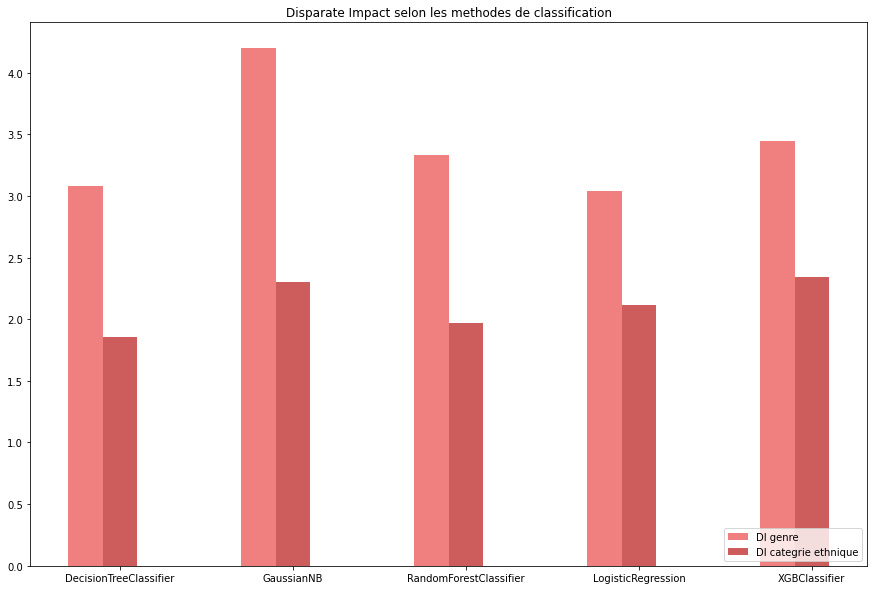

In [19]:
plt.subplots(figsize=(15,10))

plt.bar(x=[0,30,60,90,120], height=DIs_sex, width=6, align='center', color='lightcoral', label="DI genre")
plt.bar(x=[6,36,66,96,126], height=DIs_race, width=6, align='center', color='indianred', label="DI categrie ethnique")

plt.title('Disparate Impact selon les methodes de classification')
plt.xticks([6,36,66,96,126],['DecisionTreeClassifier', 
                             'GaussianNB', 
                             'RandomForestClassifier', 
                             'LogisticRegression',
                             'XGBClassifier'])
plt.legend(loc="lower right")

plt.show()

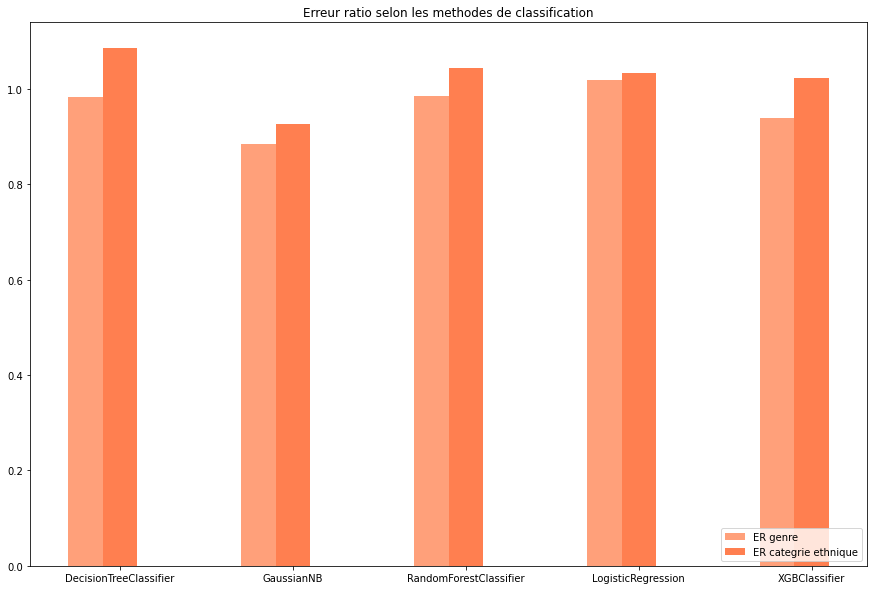

In [20]:
plt.subplots(figsize=(15,10))

plt.bar(x=[0,30,60,90,120], height=ERs_sex, width=6, align='center', color='lightsalmon', label="ER genre")
plt.bar(x=[6,36,66,96,126], height=ERs_race, width=6, align='center', color='coral', label="ER categrie ethnique")

plt.title('Erreur ratio selon les methodes de classification')
plt.xticks([6,36,66,96,126],['DecisionTreeClassifier', 
                             'GaussianNB', 
                             'RandomForestClassifier', 
                             'LogisticRegression',
                             'XGBClassifier'])
plt.legend(loc="lower right")

plt.show()

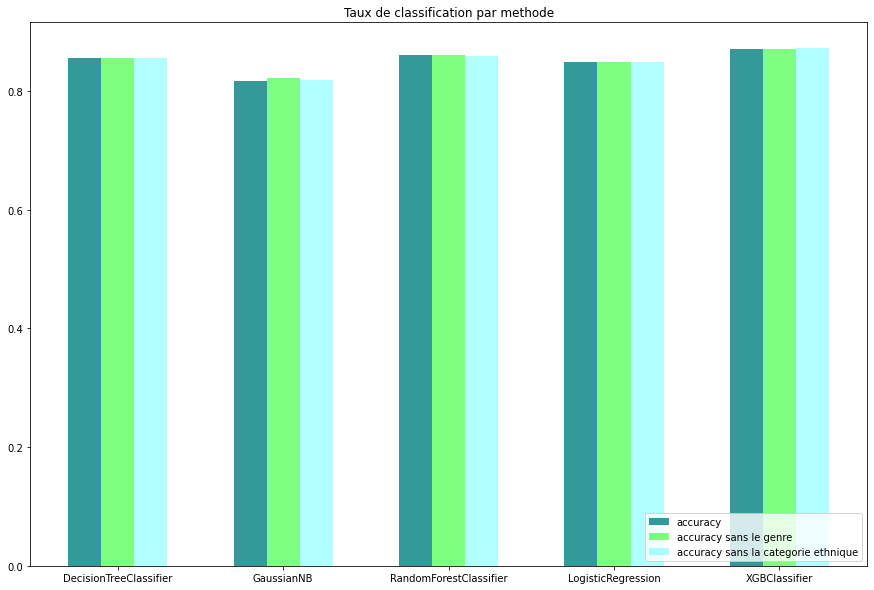

In [21]:
plt.subplots(figsize=(15,10))

plt.bar(x=[0,30,60,90,120], height=accuracies, width=6, align='center', alpha=0.8, color='teal', label="accuracy")
plt.bar(x=[6,36,66,96,126], height=accuracies_without_sex, width=6, align='center', alpha=0.5, color='lime', label="accuracy sans le genre")
plt.bar(x=[12,42,72,102,132], height=accuracies_without_race, width=6, align='center', alpha=0.3, color='cyan', label="accuracy sans la categorie ethnique")

plt.title('Taux de classification par methode')
plt.xticks([6,36,66,96,126],['DecisionTreeClassifier', 
                             'GaussianNB', 
                             'RandomForestClassifier', 
                             'LogisticRegression',
                             'XGBClassifier'])
plt.legend(loc="lower right")

plt.show()

Nous pouvons deja voir ici que les 5 classifieurs choisis ont tous un taux de classification superieur a 80%. La classification naive bayesienne semble etre la moins efficace.

## Correction des biais par re-échantillonage

Dans cette partie, nous allons essayer de re-échantilloner les données de manière à ce qu'il n'y ai plus de biais (on cherche à corriger le disparat impact mais pas forcément l'error ratio).
* Séparer la base de données d'apprentissage en 4 sous-bases :
    * $B_1$ les femmes avec un salaire supérieur à 50 000\$
    * $B_2$ les hommes avec un salaire supérieur à 50 000\$
    * $B_3$ les femmes avec un salaire inférieur à 50 000\$
    * $B_4$ les hommes avec un salaire inférieur à 50 000\$
* sur-échantillonner la $B_1$ de manière à ce qu'elle soit de la même taille que $B_2$
* sur-échantillonner la $B_4$ de manière à ce qu'elle soit de la même taille que $B_3$
* concatener les 4 bases et calculer le disparate impact de $Y_{train}$ et $S_{train}$
* entrainer un classifieur et caculer le taux de classification et le disparate impact de $\hat{Y}_{test}$ et $S_{test}$
* Avec les algorithmes précédents essayer de régler les paramètres de manière à avoir un disparate impact entre $0.8$ et $1.3$ et le plus haut taux de classification possible. Faire des graphiques comparatifs des résultats pour le taux d'erreur, le disparate impact et l'error ratio.


In [22]:
# 0 = homme, 1 = femme

df_train, df_test = train_test_split(df, test_size = 0.3)

B1 = df_train[ (df_train.sex==1) & (df_train.income==1) ]
B2 = df_train[ (df_train.sex==0) & (df_train.income==1) ]
B3 = df_train[ (df_train.sex==1) & (df_train.income==0) ]
B4 = df_train[ (df_train.sex==0) & (df_train.income==0) ]

print("INITIALEMENT NOUS AVIONS :")
print("proportion de revenu > 50K :", sum( df_train.income==1 ) / df_train.shape[0] )
print("proportion de revenu <= 50K :", sum( df_train.income==0 ) / df_train.shape[0] )

# On veut des proportions egales d hommes et de femmes mais on veut garder les memes proportions de classes de revenu.

count_B1 = B1.shape[0]
count_B2 = B2.shape[0]

over_sampling_for_B1 = B1.sample(count_B2-count_B1, replace=True)
B1_over_sampling = pds.concat([B1, over_sampling_for_B1], axis=0)

count_B3 = B3.shape[0]
count_B4 = B4.shape[0]

over_sampling_for_B3 = B3.sample(count_B4-count_B3, replace=True)
B3_over_sampling = pds.concat([B3, over_sampling_for_B3], axis=0)

new_df = pds.concat([B1_over_sampling, B2, B3_over_sampling, B4], axis=0)

print("\nAPRES SURECHANTILLONAGE DE B1 ET B3 NOUS AVONS :")
print("proportion de revenu > 50K :", sum( new_df.income==1 ) / new_df.shape[0] ) # !=24%
print("proportion de revenu <= 50K :", sum( new_df.income==0 ) / new_df.shape[0] ) # !=76%
print("Les proportions de revenus ont changé...")

# Pour garder les proportions surechantillonons un peu les revenus <= 50K :

prop_to_keep = sum( df_train.income==0 ) / df_train.shape[0]
obs_to_add_in_each_class = int(((prop_to_keep*new_df.shape[0] -  sum(new_df.income==0)) / (1-prop_to_keep))/2)

count_B3 = B3.shape[0]
count_B4 = B4.shape[0]

over_sampling_for_B3 = B3_over_sampling.sample(obs_to_add_in_each_class, replace=True)
over_sampling_for_B4 = B4.sample(obs_to_add_in_each_class, replace=True)

new_B3_B4 = pds.concat([over_sampling_for_B4, over_sampling_for_B3], axis=0)

final_df = pds.concat([new_df, new_B3_B4], axis=0)

print("\nAPRES UN NOUVEAU SURECHANTILLONNAGE DES REVENUS <=50K :")

print("proportion de revenu > 50K sachant homme", final_df[ (final_df.sex==0) & (final_df.income==1) ].shape[0] / 
      final_df[ final_df.sex==0 ].shape[0] )
print("proportion de revenu > 50K sachant femme", final_df[ (final_df.sex==1) & (final_df.income==1) ].shape[0] / 
      final_df[ final_df.sex==1 ].shape[0] )

print("proportion de revenu <= 50K sachant homme", final_df[ (final_df.sex==0) & (final_df.income==0) ].shape[0] / 
      final_df[ final_df.sex==0 ].shape[0] )
print("proportion de revenu <= 50K sachant femme", final_df[ (final_df.sex==1) & (final_df.income==0) ].shape[0] / 
      final_df[ final_df.sex==1 ].shape[0] )

print("proportion de revenu > 50K :", sum( final_df.income==1 ) / final_df.shape[0] ) # =24%
print("proportion de revenu <= 50K :", sum( final_df.income==0 ) / final_df.shape[0] ) # =76% 

INITIALEMENT NOUS AVIONS :
proportion de revenu > 50K : 0.24122499122499122
proportion de revenu <= 50K : 0.7587750087750088

APRES SURECHANTILLONAGE DE B1 ET B3 NOUS AVONS :
proportion de revenu > 50K : 0.3069065506787927
proportion de revenu <= 50K : 0.6930934493212073
Les proportions de revenus ont changé...

APRES UN NOUVEAU SURECHANTILLONNAGE DES REVENUS <=50K :
proportion de revenu > 50K sachant homme 0.24123284123284122
proportion de revenu > 50K sachant femme 0.24123284123284122
proportion de revenu <= 50K sachant homme 0.7587671587671587
proportion de revenu <= 50K sachant femme 0.7587671587671587
proportion de revenu > 50K : 0.24123284123284122
proportion de revenu <= 50K : 0.7587671587671587


In [23]:
df_train, df_test = train_test_split(final_df, test_size = 0.3)

X_test = df_test.drop('income', axis = 1)
Y_test = df_test['income']

X_train = df_train.drop('income', axis = 1)
Y_train = df_train['income']

In [24]:
non_accuracies2 = []

DIs_sex2 = []
DIs_race2 = []

ERs_sex2 = []
ERs_race2 = []

for i in tqdm(range(len(classifiers))):
    
    model = classifiers[i]
    model.fit(X_train, Y_train)
    accuracy2 = round(model.score(X_test,Y_test),3)
    non_accuracies2.append(1-accuracy2)
    
    Yhat = model.predict(X_test)
    
    DIs_sex2.append(disparate_impact(Yhat,X_test.sex))
    DIs_race2.append(disparate_impact(Yhat,X_test.race))
    
    ERs_sex2.append(erreur_ratio(Y_test,Yhat,X_test.sex))
    ERs_race2.append(erreur_ratio(Y_test,Yhat,X_test.race))

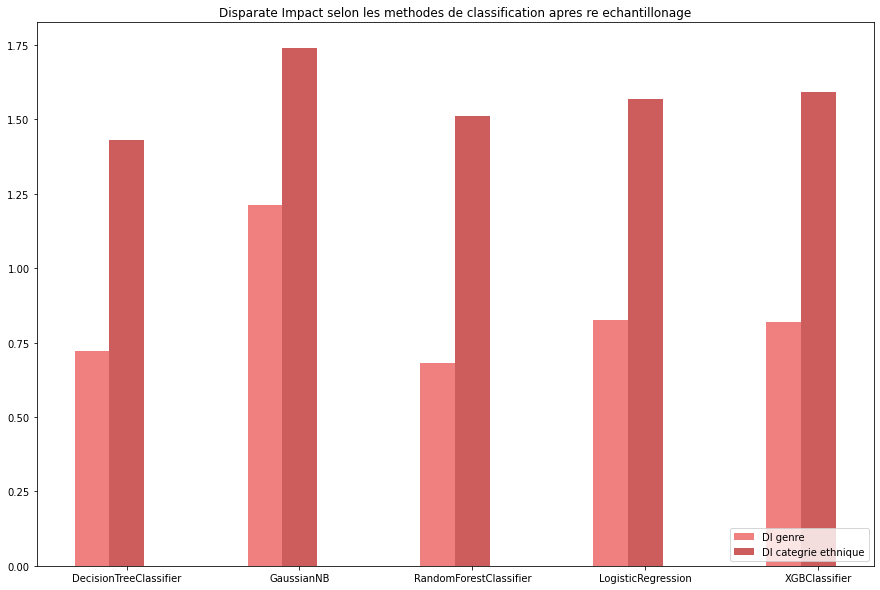

In [25]:
plt.subplots(figsize=(15,10))

plt.bar(x=[0,30,60,90,120], height=DIs_sex2, width=6, align='center', color='lightcoral', label="DI genre")
plt.bar(x=[6,36,66,96,126], height=DIs_race2, width=6, align='center', color='indianred', label="DI categrie ethnique")

plt.title('Disparate Impact selon les methodes de classification apres re echantillonage')
plt.xticks([6,36,66,96,126],['DecisionTreeClassifier', 
                             'GaussianNB', 
                             'RandomForestClassifier', 
                             'LogisticRegression',
                             'XGBClassifier'])
plt.legend(loc="lower right")

plt.show()

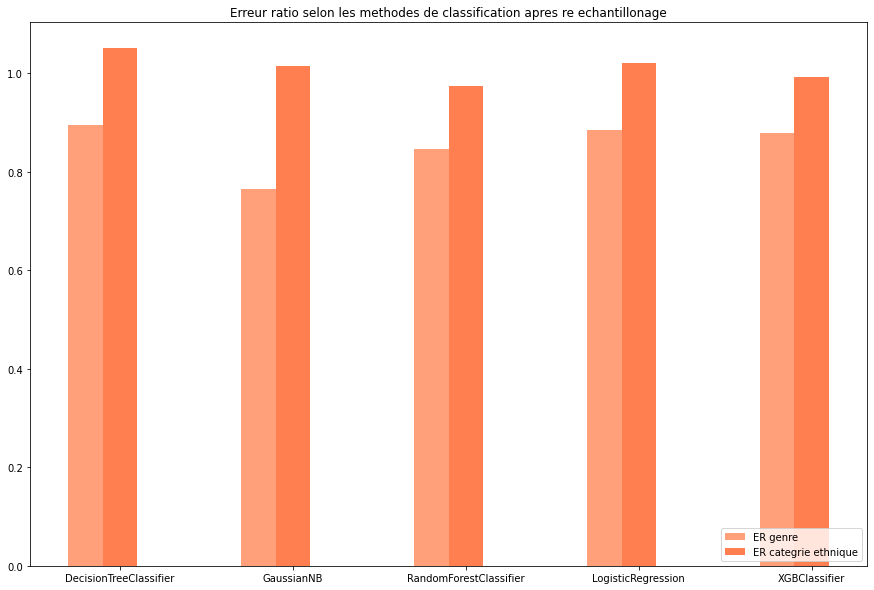

In [26]:
plt.subplots(figsize=(15,10))

plt.bar(x=[0,30,60,90,120], height=ERs_sex2, width=6, align='center', color='lightsalmon', label="ER genre")
plt.bar(x=[6,36,66,96,126], height=ERs_race2, width=6, align='center', color='coral', label="ER categrie ethnique")

plt.title('Erreur ratio selon les methodes de classification apres re echantillonage')
plt.xticks([6,36,66,96,126],['DecisionTreeClassifier', 
                             'GaussianNB', 
                             'RandomForestClassifier', 
                             'LogisticRegression',
                             'XGBClassifier'])
plt.legend(loc="lower right")

plt.show()

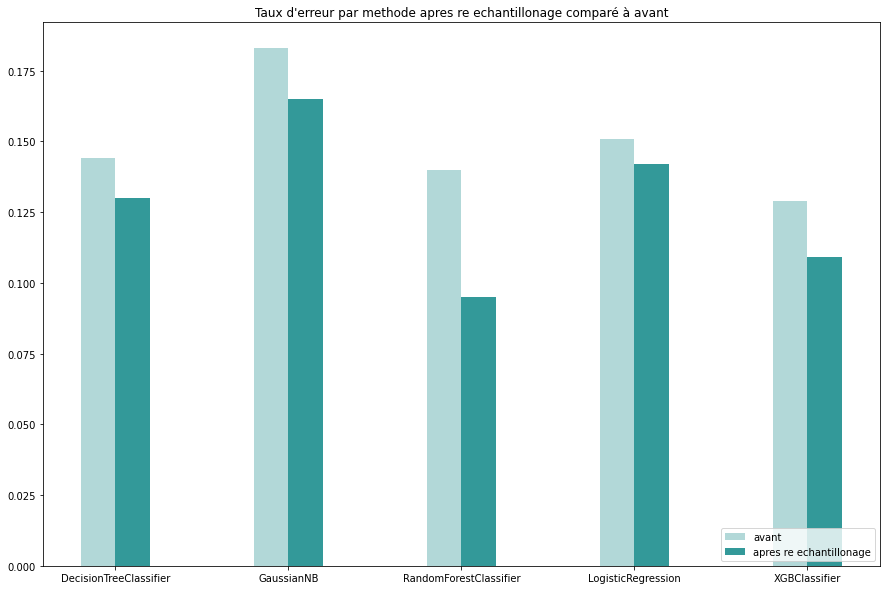

In [27]:
plt.subplots(figsize=(15,10))

plt.bar(x=[0,30,60,90,120], height=1-np.array(accuracies), width=6, align='center', alpha=0.3, color='teal', label="avant")
plt.bar(x=[6,36,66,96,126], height=non_accuracies2, width=6, align='center', alpha=0.8, color='teal', label="apres re echantillonage")

plt.title("Taux d'erreur par methode apres re echantillonage comparé à avant")
plt.xticks([3,33,63,93,123],['DecisionTreeClassifier', 
                             'GaussianNB', 
                             'RandomForestClassifier', 
                             'LogisticRegression',
                             'XGBClassifier'])
plt.legend(loc="lower right")

plt.show()

## Correction des biais par réglage du seuil

A partir des données non ré-echantillonnées :
* entrainer un classifieur sur la base d'apprentissage
* utiliser predict_proba pour prédire $\hat{P}(Y=1)$ 

Pour prédire on utilise la règle $\hat{Y}=1$ si $\hat{P}(Y=1)>t$. Par défaut, les algorithmes utilisent $t=0.5$
* Sur la base de test, choisir un seuil $t_f$ pour les femmes (on gardera $t=0.5$ pour les hommes) de manière à obtenir un disparate impact proche de 1. Calculer le taux de classification
* comparer avec la méthode précédente
* Avec les algorithmes précédents essayer de régler les paramètres de manière à avoir un disparate impact entre $0.8$ et $1.3$ et le plus haut taux de classification possible. Faire des graphiques comparatifs des résultats pour le taux d'erreur, le disparate impact et l'error ratio.

In [28]:
df_train, df_test = train_test_split(df, test_size = 0.3)
X_test = df_test.drop('income', axis = 1)
Y_test = df_test['income']
X_train = df_train.drop('income', axis = 1)
Y_train = df_train['income']

In [29]:
accuracies_sex = []
accuracies_race = []

DI_proche1_sex = []
DI_proche1_race = []

ERs_sex3 = []
ERs_race3 = []

opti_seuil_femmes_sex = []
opti_seuil_exotic_race = []

for i in tqdm(range(len(classifiers))):
    
    clf = classifiers[i]
    clf.fit(X_train, Y_train)
    
    DIsex = np.array([])
    DIrace = np.array([])
    
    K = clf.predict_proba(X_test)

    for seuil in np.linspace(0,1,21):
        
        new_Y_sex = np.array( ((K[:,1]>0.5)&(X_test.sex==0)) | ((K[:,1]>seuil)&(X_test.sex==1)) )
        
        DIsex = np.append(DIsex, disparate_impact(new_Y_sex, X_test.sex))
        
        new_Y_race = np.array( ((K[:,1]>0.5)&(X_test.race==0)) | ((K[:,1]>seuil)&(X_test.race==1)) )
        
        DIrace = np.append(DIrace, disparate_impact(new_Y_race, X_test.race))
            
    idx_opt_DIsex = np.argmin(abs(DIsex-1))
    idx_opt_DIrace = np.argmin(abs(DIrace-1))
    
    DI_proche1_sex.append(DIsex[idx_opt_DIsex])
    DI_proche1_race.append(DIrace[idx_opt_DIrace])
    
    seuil_opti_sex = np.linspace(0,1,21)[idx_opt_DIsex]
    seuil_opti_race = np.linspace(0,1,21)[idx_opt_DIrace]
    
    Yhat_sex = np.array(((K[:,1]>0.5)&(X_test.sex==0)) | ((K[:,1]>seuil_opti_sex)&(X_test.sex==1)))
    Yhat_race = np.array(((K[:,1]>0.5)&(X_test.race==0)) | ((K[:,1]>seuil_opti_race)&(X_test.race==1)))
    
    accuracies_sex.append(sum(Yhat_sex==Y_test)/len(Y_test))
    accuracies_race.append(sum(Yhat_race==Y_test)/len(Y_test))
    
    ERs_sex3.append(erreur_ratio(Y_test,Yhat_sex,X_test.sex))
    ERs_race3.append(erreur_ratio(Y_test,Yhat_race,X_test.race))
    
    opti_seuil_femmes_sex.append(seuil_opti_sex)
    opti_seuil_exotic_race.append(seuil_opti_race)


In [30]:
opti_seuil_femmes_sex

[0.1, 0.0, 0.1, 0.1, 0.05]

In [31]:
opti_seuil_exotic_race

[0.35000000000000003, 0.05, 0.30000000000000004, 0.25, 0.2]

Que ce soit pour les femmes ou les individus non blancs, il resulte du reglage de seuil la necessite de choisir un seuil de probabilite bas pour predire la classe du revenu. On remarque ici que les seuils choisi pour les femmes (pour les differents classifieurs) et pour les individus non blancs sont bien inferieurs a 0.5.

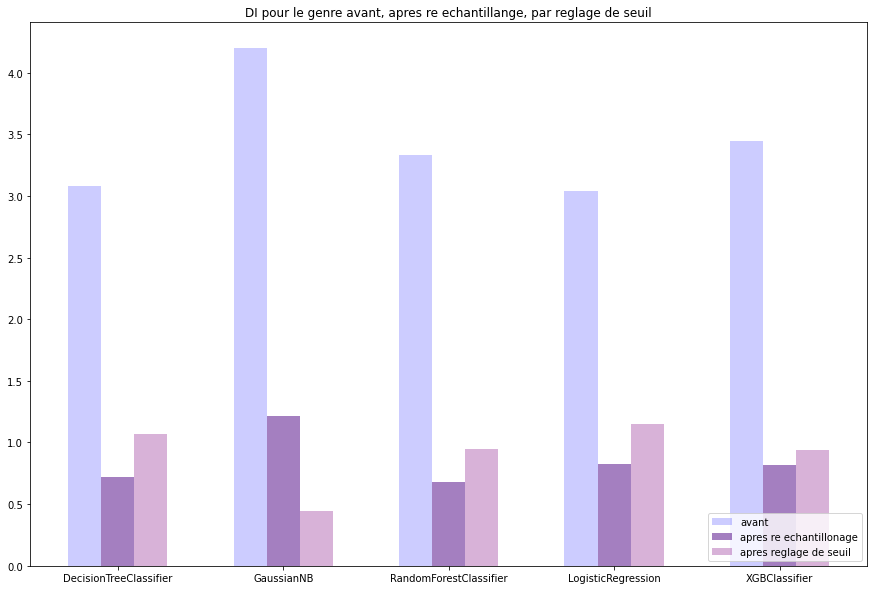

In [32]:
plt.subplots(figsize=(15,10))

plt.bar(x=[0,30,60,90,120], height=DIs_sex, width=6, align='center', alpha=0.2, color='blue', label="avant")
plt.bar(x=[6,36,66,96,126], height=DIs_sex2, width=6, align='center', alpha=0.5, color='indigo', label="apres re echantillonage")
plt.bar(x=[12,42,72,102,132], height=DI_proche1_sex, width=6, align='center', alpha=0.3, color='purple', label="apres reglage de seuil")

plt.title("DI pour le genre avant, apres re echantillange, par reglage de seuil")
plt.xticks([6,36,66,96,126],['DecisionTreeClassifier', 
                             'GaussianNB', 
                             'RandomForestClassifier', 
                             'LogisticRegression',
                             'XGBClassifier'])
plt.legend(loc="lower right")

plt.show()

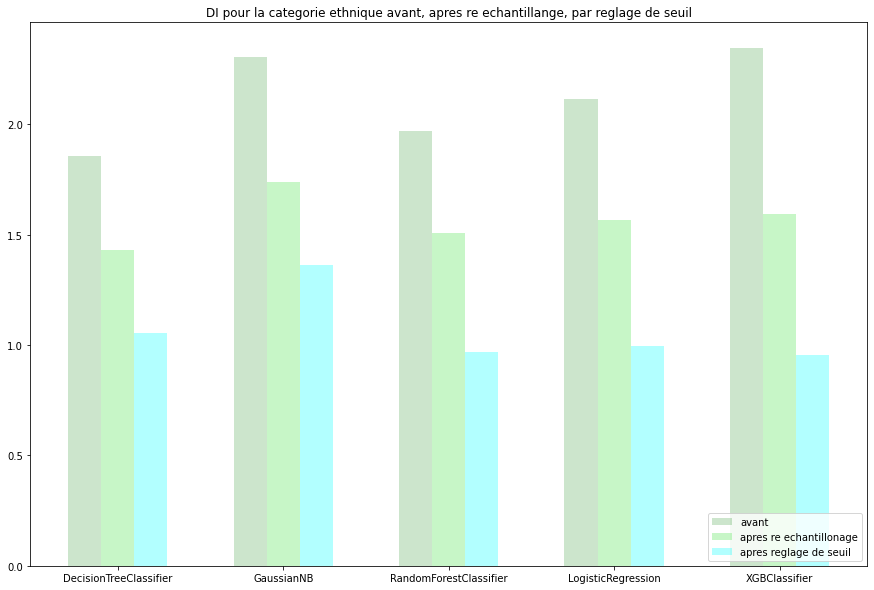

In [33]:
plt.subplots(figsize=(15,10))

plt.bar(x=[0,30,60,90,120], height=DIs_race, width=6, align='center', alpha=0.2, color='green', label="avant")
plt.bar(x=[6,36,66,96,126], height=DIs_race2, width=6, align='center', alpha=0.5, color='lightgreen', label="apres re echantillonage")
plt.bar(x=[12,42,72,102,132], height=DI_proche1_race, width=6, align='center', alpha=0.3, color='cyan', label="apres reglage de seuil")

plt.title("DI pour la categorie ethnique avant, apres re echantillange, par reglage de seuil")
plt.xticks([6,36,66,96,126],['DecisionTreeClassifier', 'GaussianNB', 'RandomForestClassifier', 'LogisticRegression','XGBClassifier'])
plt.legend(loc="lower right")

plt.show()

Tout au long de ce TP nous avons calcule le disparate impact entre la variable d'interet : le revenu et les variables a proteger : le genre et la categorie ethnique.

Pour calculer cette mesure de la dependance entre la variable d'interet et la variable a proteger nous avions besoin du vecteur de prediction de la variable d'interet pour un certain vecteur de la base de test de la variable a proteger.

Nous avons donc choisi 5 algorithmes de classification afin de produire le vecteur de prediction du revenu et ainsi nous avons applique la formule du disparate impact pour les 5 differents classifieurs.

Il est clair qu'au commencement du TP les disparates impacts ont revele la presence d'un biais dans nos donnees, biais vis a vis du genre et vis a vis de la categorie ethnique.

Nous avons donc mis en oeuvre 2 techniques afin de transformer le tableau de donnees pour effacer ce biais. La methode du re echantillonage (sur-echantillonage) et la methode du reglage de seuil.

Tout d'abord les differents classifieurs donnent des valeurs de disparate impact differentes, qui peuvent varier jusqu'a plus ou moins 1 point. Mais globalement on remarque la meme tendance pour tous les classifieurs. La methode du re echantillonage a ete efficace pour le genre et l'ethnie puisqu'elle a abaisse le DI aux alentours de 1, entre 0.75 et 1.25 en moyenne. Neanmoins, la methode par reglage du seuil a ete encore plus efficace car elle a rapproche encore plus les DI autour de 1 pour la plupart des classifieurs.

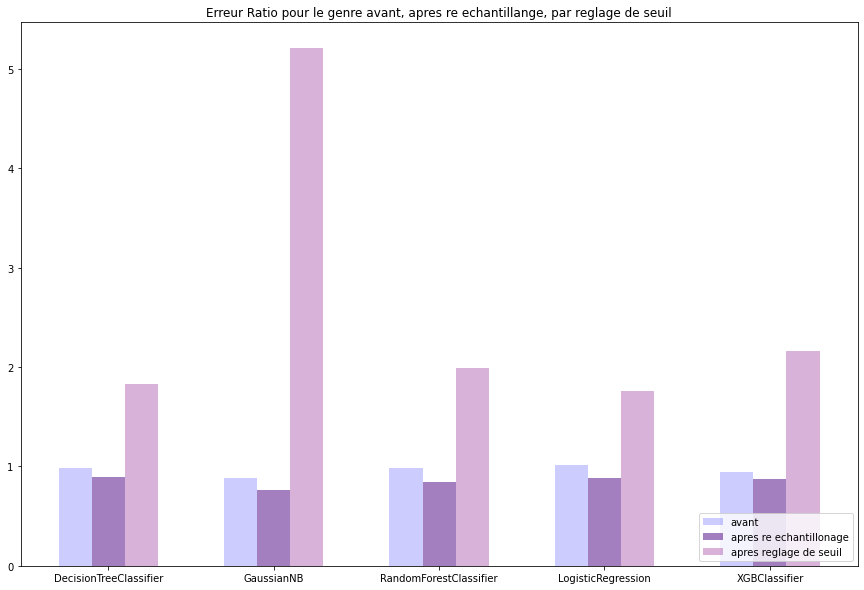

In [34]:
plt.subplots(figsize=(15,10))

plt.bar(x=[0,30,60,90,120], height=ERs_sex, width=6, align='center', alpha=0.2, color='blue', label="avant")
plt.bar(x=[6,36,66,96,126], height=ERs_sex2, width=6, align='center', alpha=0.5, color='indigo', label="apres re echantillonage")
plt.bar(x=[12,42,72,102,132], height=ERs_sex3, width=6, align='center', alpha=0.3, color='purple', label="apres reglage de seuil")

plt.title("Erreur Ratio pour le genre avant, apres re echantillange, par reglage de seuil")
plt.xticks([6,36,66,96,126],['DecisionTreeClassifier', 'GaussianNB', 'RandomForestClassifier', 'LogisticRegression','XGBClassifier'])
plt.legend(loc="lower right")

plt.show()

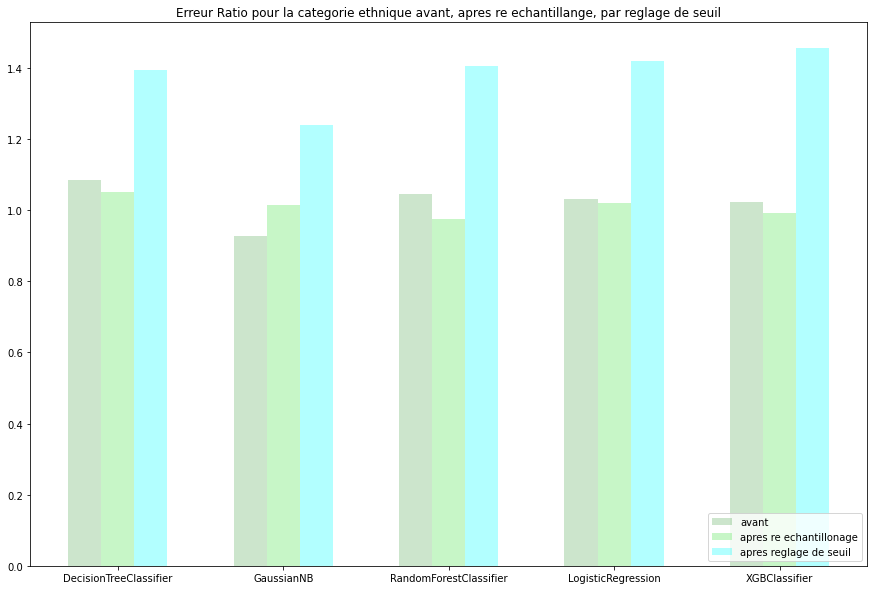

In [35]:
plt.subplots(figsize=(15,10))

plt.bar(x=[0,30,60,90,120], height=ERs_race, width=6, align='center', alpha=0.2, color='green', label="avant")
plt.bar(x=[6,36,66,96,126], height=ERs_race2, width=6, align='center', alpha=0.5, color='lightgreen', label="apres re echantillonage")
plt.bar(x=[12,42,72,102,132], height=ERs_race3, width=6, align='center', alpha=0.3, color='cyan', label="apres reglage de seuil")

plt.title("Erreur Ratio pour la categorie ethnique avant, apres re echantillange, par reglage de seuil")
plt.xticks([6,36,66,96,126],['DecisionTreeClassifier', 'GaussianNB', 'RandomForestClassifier', 'LogisticRegression','XGBClassifier'])
plt.legend(loc="lower right")

plt.show()

Mous avons de la meme maniere calcule les erreurs ratio, qui cette fois, mesure la dependance entre l'erreur et la variable a proteger.

Au debut du TP, l'erreur ratio ne nous indiquait pas particulierement la presence d'un biais dans les donnees, pour le genre et pour l'ethnie, comme avait pu le faire le disparate impacte. En effet, l'erreur et les variables a proteger n'etaient deja pas tres dependantes. Contrairement a ce que nous avons pu voir pour le disparate impact, ici, l'erreur ratio est endommagee par la methode de reglage de seuil. La methode par re echantillonage, elle, a probablement ameliore quelque peu l'erreur ratio mais la difference avec l'erreur ratio que nous avions au commencement n'est pas grande.

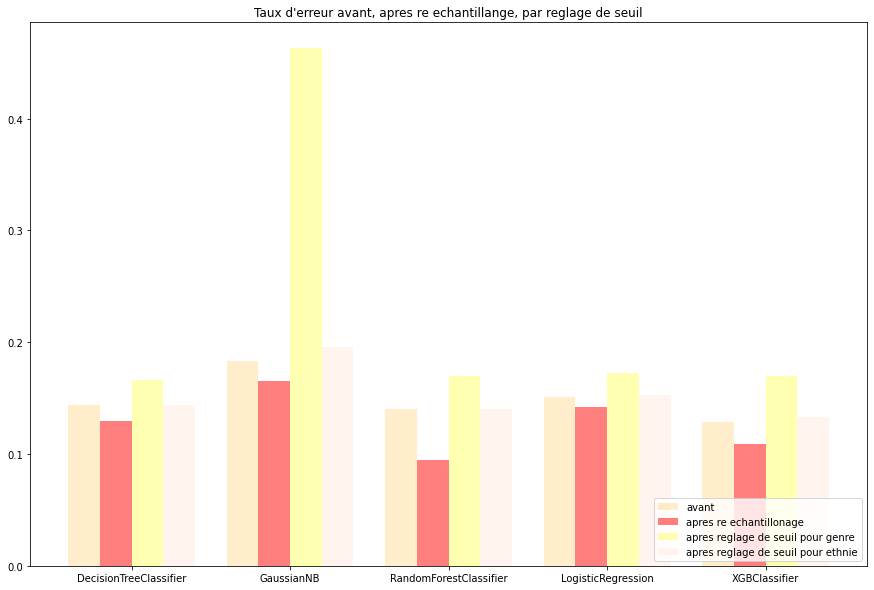

In [36]:
plt.subplots(figsize=(15,10))

plt.bar(x=[0,30,60,90,120], height=1-np.array(accuracies), width=6, align='center', alpha=0.2, color='orange', label="avant")
plt.bar(x=[6,36,66,96,126], height=non_accuracies2, width=6, align='center', alpha=0.5, color='red', label="apres re echantillonage")
plt.bar(x=[12,42,72,102,132], height=1-np.array(accuracies_sex), width=6, align='center', alpha=0.3, color='yellow', label="apres reglage de seuil pour genre")
plt.bar(x=[18,48,78,108,138], height=1-np.array(accuracies_race), width=6, align='center', alpha=1, color='seashell', label="apres reglage de seuil pour ethnie")

plt.title("Taux d'erreur avant, apres re echantillange, par reglage de seuil")
plt.xticks([9,39,69,99,129],['DecisionTreeClassifier', 'GaussianNB', 'RandomForestClassifier', 'LogisticRegression','XGBClassifier'])
plt.legend(loc="lower right")

plt.show()

En moyenne la classifieur avec le meilleur taux de classification est probablement le XGBClassifieur qui est un gradient boosting classifier. La regression logistique fonctionne tres bien ici, tout comme fonctionnent l'arbre de decison et le random forest. Globalement c'est la methode naive bayesienne qui donne le plus haut taux d'erreur sur nos donnees.

Le re echantillonage et le reglage du seuil n'ont pas, ou peu, endommage les taux de classifications (sauf pour GaussianNB). La methode de correction du biais par re echantillonage a meme ameliore la prediction pour tous les classifieurs.

En ce basant sur le disparate impact nous avons, grace a la methode par reglage de seuil, quasiment efface le biais des donnees par rapport au genre ou a la categorie ethnique. L'erreur ratio ne peut pas en dire autant.

## Bonus
Vous êtes encouragés à :
* tester d'autres méthodes pour les variables manquantes
* Faire le même travail en prenant la catégorie éthnique comme variable à proteger